In [19]:
import os, csv
os.chdir('/scratch/rcj50704/LOL/DLscript')
import pandas as pd
import torch
from transformers import RobertaModel, AutoTokenizer, AutoModel, AutoModelForMaskedLM
import dataloader as dl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import torch.nn as nn
import glob
from scipy.spatial.distance import jaccard, cosine, euclidean, sqeuclidean
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
# from sklearn.metrics import silhouette_score
from sklearn import metrics
from collections import Counter
# plt.rcParams["xtick.top"] = True
os.environ["TOKENIZERS_PARALLELISM"] = "false"
#k-nn
from tqdm import tqdm
import faiss # Or import annoy
!ls -l /work/ah2lab/soumya/UniprotDatasets/BalancedUniprot
# !pip install --upgrade scikit-learn

total 2529935
-rw-r--r-- 1 sb66469 ah2lab 1464830557 May 29 09:06 Train.csv
-rw-r--r-- 1 sb66469 ah2lab 1323091661 May 29 09:06 Valid.csv


In [20]:
# data_dir="/work/ah2lab/vatsal/Data/final_csv/"
def load_df(root_dir, file_prefix):
    # data_dir = "/work/ah2lab/soumya/"
    file_ptrn = f"{files}"
    all_files = glob.glob(f"{data_dir}/{file_ptrn}*.csv")
    print(all_files)
    df= pd.DataFrame()   #load train and test separately
    for filename in all_files:
        temp_df = pd.read_csv(filename, usecols=['EC','Sequence'])
        df = pd.concat([df, temp_df], ignore_index=True)
    return df
train_df = load_df('UniprotDatasets/BalancedUniprot/Train')
# test_df = load_df('SwissprotDatasets/test')
len(train_df)#, len(test_df) #179587 5399  #27877140 unbala, #1171000

['/work/ah2lab/soumya//UniprotDatasets/BalancedUniprot/Train.csv']


1171000

In [22]:
filtered_df = train_df.groupby('EC').head(20) #.sort_values('EC') #.groupby('EC').head(5) do not group only sort
# train_sequences = filtered_df['Sequence'].tolist()
# train_EC = filtered_df['EC'].tolist()

# filtered_df = test_df.groupby('EC').head(2).sort_values('EC') #.groupby('EC').head(5) do not group only sort
# test_sequences = filtered_df['Sequence'].tolist()
# test_EC = filtered_df['EC'].tolist()
len(filtered_df)


93680

In [23]:
!mkdir UniprotDatasets
filtered_df.to_csv('UniprotDatasets/BalancedUniprot_train.csv', index=False)

mkdir: cannot create directory ‘UniprotDatasets’: File exists


In [27]:
def get_embedding_stats(embeddings):
    min_embeddings, _ = torch.min(embeddings, dim=1)
    max_embeddings, _ = torch.max(embeddings, dim=1)
    avg_embeddings = torch.mean(embeddings, dim=-2) # torch.sum(attention_mask*embeddings, axis=-2)/torch.sum(attention_mask, axis=1)
    return embeddings[:, 0, :], min_embeddings, max_embeddings, avg_embeddings
def compute_cosine_similarity_in_chunks(embeddings, chunk_size=1000):
    n = embeddings.size(0)
    similarity_matrix = torch.zeros((n, n))
    for i in range(0, n, chunk_size):
        for j in range(0, n, chunk_size):
            end_i = min(i + chunk_size, n)
            end_j = min(j + chunk_size, n)
            chunk1 = embeddings[i:end_i]
            chunk2 = embeddings[j:end_j]
            similarity_chunk = torch.nn.functional.cosine_similarity(chunk1.unsqueeze(1), chunk2.unsqueeze(0), dim=2)
            similarity_matrix[i:end_i, j:end_j] = similarity_chunk.cpu()
    return similarity_matrix

(46840, 46840)

In [39]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
# model = AutoModelForMaskedLM.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
model = RobertaModel.from_pretrained("models/FinetunedModel/")
tokenizer = dl.load_tokenizer("FinetunedModel/") #FinetunedModel LOLBERTv4
# tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-2.5b-multi-species", trust_remote_code=True, local_files_only=True)
# model = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-2.5b-multi-species", trust_remote_code=True, local_files_only=True)
model.to(device)
device_ids = [x for x in range(torch.cuda.device_count())]
model = nn.DataParallel(model, device_ids=device_ids)

Some weights of the model checkpoint at models/FinetunedModel/ were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at models/FinetunedModel/ and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer class 

In [40]:
batch_size = 512 #64 #dnabert
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        # store encodings internally
        self.encodings = encodings
    def __len__(self):
        # return the number of samples
        return self.encodings['input_ids'].shape[0]
    def __getitem__(self, i):
        # return dictionary of input_ids, attention_mask, and labels for index i
        return {key: tensor[i] for key, tensor in self.encodings.items()}
train_batch = tokenizer(train_sequences, padding='max_length', truncation=True) #lolbert
# test_batch = tokenizer(test_sequences, padding='max_length', truncation=True) #lolbert
# train_batch = tokenizer(train_sequences, max_length=512, return_tensors='pt', truncation=True, padding=True) #dnabert
# test_batch = tokenizer(test_sequences, max_length=512, return_tensors='pt', truncation=True, padding=True) #dnabert
# train_batch = tokenizer.batch_encode_plus(train_sequences, max_length=128, return_tensors='pt', truncation=True, padding=True) #nuc
# test_batch = tokenizer.batch_encode_plus(test_sequences, max_length=128, return_tensors='pt', truncation=True, padding=True) #nuc


train_encodings = {'input_ids': torch.tensor(train_batch['input_ids']), 'attention_mask': torch.tensor(train_batch['attention_mask'])} #, 'labels': torch.tensor(batch['input_ids'])
# test_encodings = {'input_ids': torch.tensor(test_batch['input_ids']), 'attention_mask': torch.tensor(test_batch['attention_mask'])} #, 'labels': torch.tensor(batch['input_ids'])
train_dataset = Dataset(train_encodings)
# test_dataset = Dataset(test_encodings)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
def get_embeddings(loader):
    loop = tqdm(loader, leave=True)
    embeddings = []#torch.Tensor()#.to(device)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)#     labels = batch['labels'].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask) # for lol and dna bert
#             outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True) # for nuc trans
        batch_embeddings = outputs.last_hidden_state.cpu() # LOLBERT
#         batch_embeddings = outputs.hidden_states.cpu() #dnabert
#         batch_embeddings = outputs['hidden_states'][-1].cpu() #for nuc trans
        embeddings.append(batch_embeddings)
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings
train_embeddings = get_embeddings(train_loader)
# test_embeddings = get_embeddings(test_loader)

100%|██████████| 52/52 [00:19<00:00,  2.64it/s]


In [77]:
def generate_labels(ec_list):
#     print(len(ec_list))
    labels = []
    last_label = ['x', 'x', 'x', 'x']
    for ec in ec_list:
        if ec.split('.')[:3] != last_label[:3]:
#             print(f"ls{last_label}")
            labels.append('.'.join(ec.split('.')[:3]) + '.x')
            last_label = ec.split('.')
        else:
            labels.append('')
    return labels
labels = generate_labels(EC)

# silhouette_score

# SwissprotDatasets/UnbalancedSwissprot

In [30]:
#nuc trans
stat = ['class', 'min', 'max', 'avg']
for name, item in zip(stat, get_embedding_stats(train_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, train_EC)}")

silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat class = -0.22480767965316772
silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat min = -0.10500644147396088
silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat max = -0.10483293235301971
silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat avg = -0.25811976194381714


In [34]:
#dnabert
stat = ['class', 'min', 'max', 'avg']
for name, item in zip(stat, get_embedding_stats(train_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, train_EC)}")

silhouette_score of zhihan1996/DNABERT-2-117M for stat class = -0.29008084535598755
silhouette_score of zhihan1996/DNABERT-2-117M for stat min = -0.14599432051181793
silhouette_score of zhihan1996/DNABERT-2-117M for stat max = -0.08209596574306488
silhouette_score of zhihan1996/DNABERT-2-117M for stat avg = -0.38197624683380127


In [38]:
#lolbert
stat = ['class', 'min', 'max', 'avg']
for name, item in zip(stat, get_embedding_stats(train_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, train_EC)}")

silhouette_score of models/LOLBERTv4/ for stat class = -0.18550658226013184
silhouette_score of models/LOLBERTv4/ for stat min = -0.04242592304944992
silhouette_score of models/LOLBERTv4/ for stat max = -0.04678286239504814
silhouette_score of models/LOLBERTv4/ for stat avg = -0.3229919970035553


In [42]:
#finetune
stat = ['class', 'min', 'max', 'avg']
for name, item in zip(stat, get_embedding_stats(train_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, train_EC)}")

silhouette_score of models/FinetunedModel/ for stat class = -0.07863176614046097
silhouette_score of models/FinetunedModel/ for stat min = -0.0023949553724378347
silhouette_score of models/FinetunedModel/ for stat max = -0.0013639150420203805
silhouette_score of models/FinetunedModel/ for stat avg = -0.15168116986751556


# SwissprotDatasets/BalancedSwissprot

In [10]:
#dnabert
stat = ['class', 'min', 'max', 'avg']
for name, item in zip(stat, get_embedding_stats(train_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, train_EC)}")

silhouette_score of zhihan1996/DNABERT-2-117M for stat class = 0.20096200704574585
silhouette_score of zhihan1996/DNABERT-2-117M for stat min = 0.30356544256210327
silhouette_score of zhihan1996/DNABERT-2-117M for stat max = 0.3439236581325531
silhouette_score of zhihan1996/DNABERT-2-117M for stat avg = 0.13462989032268524


In [14]:
#lolbert
stat = ['class', 'min', 'max', 'avg']
for name, item in zip(stat, get_embedding_stats(train_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, train_EC)}")

silhouette_score of models/LOLBERTv4/ for stat class = 0.2623496651649475
silhouette_score of models/LOLBERTv4/ for stat min = 0.35685354471206665
silhouette_score of models/LOLBERTv4/ for stat max = 0.353497177362442
silhouette_score of models/LOLBERTv4/ for stat avg = 0.17284296452999115


In [18]:
#finetuned
stat = ['class', 'min', 'max', 'avg']
for name, item in zip(stat, get_embedding_stats(train_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, train_EC)}")

silhouette_score of models/FinetunedModel/ for stat class = 0.30603551864624023
silhouette_score of models/FinetunedModel/ for stat min = 0.369667112827301
silhouette_score of models/FinetunedModel/ for stat max = 0.36977294087409973
silhouette_score of models/FinetunedModel/ for stat avg = 0.2674078047275543


In [22]:
#nuc trans
stat = ['class', 'min', 'max', 'avg']
for name, item in zip(stat, get_embedding_stats(train_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, train_EC)}")

silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat class = 0.24610966444015503
silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat min = 0.32697179913520813
silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat max = 0.32710880041122437
silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat avg = 0.22369836270809174


In [43]:
model

DataParallel(
  (module): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(9, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

# BalancedUniprot

In [9]:
#nuc trans
stat = ['class', 'min', 'max', 'avg']
for name, item in zip(stat, get_embedding_stats(train_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, train_EC)}")

silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat class = -0.07022510468959808
silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat min = 0.03722462058067322
silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat max = 0.036594510078430176
silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat avg = -0.10712860524654388


In [13]:
#finetuned
stat = ['class', 'min', 'max', 'avg']
for name, item in zip(stat, get_embedding_stats(train_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, train_EC)}")

silhouette_score of models/FinetunedModel/ for stat class = -0.046652454882860184
silhouette_score of models/FinetunedModel/ for stat min = 0.06883422285318375
silhouette_score of models/FinetunedModel/ for stat max = 0.06909509003162384
silhouette_score of models/FinetunedModel/ for stat avg = -0.08149556070566177


In [16]:
#lolbert
stat = ['class', 'min', 'max', 'avg']
for name, item in zip(stat, get_embedding_stats(train_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, train_EC)}")

silhouette_score of models/LOLBERTv4/ for stat class = -0.06722062081098557
silhouette_score of models/LOLBERTv4/ for stat min = 0.07145857810974121
silhouette_score of models/LOLBERTv4/ for stat max = 0.06780855357646942
silhouette_score of models/LOLBERTv4/ for stat avg = -0.18002545833587646


In [20]:
#dnabert
stat = ['class', 'min', 'max', 'avg']
for name, item in zip(stat, get_embedding_stats(train_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, train_EC)}")

silhouette_score of zhihan1996/DNABERT-2-117M for stat class = -0.14012417197227478
silhouette_score of zhihan1996/DNABERT-2-117M for stat min = -0.016105787828564644
silhouette_score of zhihan1996/DNABERT-2-117M for stat max = 0.052538853138685226
silhouette_score of zhihan1996/DNABERT-2-117M for stat avg = -0.26026982069015503


## UniprotDatasets/UnbalancedUniprot

In [12]:
#lolbert
stat = ['test_class', 'test_min', 'test_max', 'test_avg']
for name, item in zip(stat, get_embedding_stats(train_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, train_EC)}")

silhouette_score of models/LOLBERTv4/ for stat test_class = -0.21399833261966705
silhouette_score of models/LOLBERTv4/ for stat test_min = -0.063469298183918
silhouette_score of models/LOLBERTv4/ for stat test_max = -0.06692159920930862
silhouette_score of models/LOLBERTv4/ for stat test_avg = -0.33726951479911804


In [15]:
#finetuned
stat = ['class', 'min', 'max', 'avg']
for name, item in zip(stat, get_embedding_stats(train_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, train_EC)}")

silhouette_score of models/FinetunedModel/ for stat test_class = -0.17350031435489655
silhouette_score of models/FinetunedModel/ for stat test_min = -0.05349848046898842
silhouette_score of models/FinetunedModel/ for stat test_max = -0.05319637060165405
silhouette_score of models/FinetunedModel/ for stat test_avg = -0.21212425827980042


In [19]:
#dnabert
stat = ['class', 'min', 'max', 'avg']
for name, item in zip(stat, get_embedding_stats(train_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, train_EC)}")

silhouette_score of zhihan1996/DNABERT-2-117M for stat class = -0.3078538775444031
silhouette_score of zhihan1996/DNABERT-2-117M for stat min = -0.17051254212856293
silhouette_score of zhihan1996/DNABERT-2-117M for stat max = -0.09251642227172852
silhouette_score of zhihan1996/DNABERT-2-117M for stat avg = -0.4108702540397644


In [23]:
#nuc trans
stat = ['class', 'min', 'max', 'avg']
for name, item in zip(stat, get_embedding_stats(train_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, train_EC)}")

silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat class = -0.22378967702388763
silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat min = -0.10620839893817902
silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat max = -0.10702206194400787
silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat avg = -0.25556647777557373


# Clustering with cosine Similarity Clustering

In [24]:
# train_class, train_min, train_max, train_avg = get_embedding_stats(train_embeddings)
test_class, test_min, test_max, test_avg = get_embedding_stats(test_embeddings)
test_class.shape

torch.Size([3431, 768])

In [13]:
# distance_matrix = np.zeros((train_class.shape[0], train_class.shape[0]))
# distance_matrix.shape

(22280, 22280)

In [9]:
def dist_matrix_chunks(embeddings, chunk_size=1000):
    n = embeddings.shape[0]
    distance_matrix = np.zeros((n, n))
    for i in range(0, n, chunk_size):
        for j in range(0, n, chunk_size):
            end_i = min(i + chunk_size, n)
            end_j = min(j + chunk_size, n)
            chunk1 = embeddings[i:end_i]
            chunk2 = embeddings[j:end_j]
            distance_chunk = cosine(embeddings[i].cpu().detach().numpy(), embeddings[j].cpu().detach().numpy())
            distance_matrix[i:end_i, j:end_j] = distance_chunk
    return distance_matrix

In [25]:
# for i in range(class_embeddings.shape[0]):
#     for j in range(i, class_embeddings.shape[0]):
#         distance_matrix[i, j] = cosine(class_embeddings[i].cpu().detach().numpy(), class_embeddings[j].cpu().detach().numpy())
distance_matrix = dist_matrix_chunks(test_class)
distance_matrix = distance_matrix + distance_matrix.T - np.diag(distance_matrix.diagonal())
distance_matrix.shape

(3431, 3431)

# BalancedSwissprot

In [47]:
stat = ['test_class', 'test_min', 'test_max', 'test_avg']
for name, item in zip(stat, get_embedding_stats(test_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, test_EC)}")

silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat test_class = -0.07805275917053223
silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat test_min = -0.027927232906222343
silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat test_max = -0.0278147105127573
silhouette_score of InstaDeepAI/nucleotide-transformer-2.5b-multi-species for stat test_avg = -0.08191379904747009


In [42]:
stat = ['test_class', 'test_min', 'test_max', 'test_avg']
for name, item in zip(stat, get_embedding_stats(test_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, test_EC)}")

silhouette_score of models/FinetunedModel/ for stat test_class = 0.013706007972359657
silhouette_score of models/FinetunedModel/ for stat test_min = 0.04614705964922905
silhouette_score of models/FinetunedModel/ for stat test_max = 0.04670119658112526
silhouette_score of models/FinetunedModel/ for stat test_avg = -0.01523165125399828


In [38]:
stat = ['test_class', 'test_min', 'test_max', 'test_avg']
for name, item in zip(stat, get_embedding_stats(test_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, test_EC)}")

silhouette_score of models/LOLBERTv4/ for stat test_class = -0.0447123758494854
silhouette_score of models/LOLBERTv4/ for stat test_min = 0.01561332680284977
silhouette_score of models/LOLBERTv4/ for stat test_max = 0.013509433716535568
silhouette_score of models/LOLBERTv4/ for stat test_avg = -0.10082883387804031


In [34]:
stat = ['test_class', 'test_min', 'test_max', 'test_avg']
for name, item in zip(stat, get_embedding_stats(test_embeddings)):
    print(f"silhouette_score of {tokenizer.name_or_path} for stat {name} = {metrics.silhouette_score(item, test_EC)}")

silhouette_score of zhihan1996/DNABERT-2-117M for stat test_class = -0.1156126856803894
silhouette_score of zhihan1996/DNABERT-2-117M for stat test_min = -0.05672323703765869
silhouette_score of zhihan1996/DNABERT-2-117M for stat test_max = -0.021831106394529343
silhouette_score of zhihan1996/DNABERT-2-117M for stat test_avg = -0.13548417389392853


In [132]:
kmeans = KMeans(n_clusters=71, random_state=41)  # Set random_state for reproducibility
km_cluster_labels = kmeans.fit_predict(train_class)
# km_cluster_labels = kmeans.labels_  
len(km_cluster_labels)

2228

In [133]:
#dnabert
pred_km_lab = kmeans.predict(test_class)
clusterbyid = {}
for i in range(len(pred_km_lab)):
    clusterbyid.setdefault(pred_km_lab[i], [])
    clusterbyid[pred_km_lab[i]].append(test_EC[i])
for item in clusterbyid.items():
    print(item)

(12, ['1.1.1.1', '1.1.1.145', '1.1.1.376', '1.1.99.37', '1.11.1.7', '1.12.2.1', '1.14.13.227', '1.14.19.9', '1.3.99.27', '1.5.98.2', '2.1.1.13', '2.3.1.233', '2.3.1.282', '2.3.1.48', '2.4.1.283', '2.6.1.100', '2.7.1.49', '2.7.10.2', '2.7.7.105', '2.7.7.23', '3.2.1.14', '3.4.17.18', '3.5.3.23', '3.5.4.29', '4.1.2.56', '4.1.99.20', '4.2.3.124', '4.3.1.23', '5.1.1.17', '5.3.1.22', '5.3.1.23', '6.1.1.21', '6.2.1.12'])
(69, ['1.1.1.100', '1.1.1.130', '1.1.1.17', '1.1.1.37', '1.1.1.410', '1.13.11.1', '1.13.11.3', '1.3.1.25', '1.3.1.28', '2.1.1.228', '2.5.1.18', '2.5.1.55', '2.5.1.61', '2.7.1.113', '2.7.1.26', '2.7.1.59', '2.7.7.33', '2.7.7.90', '2.8.3.8', '3.1.3.6', '3.4.21.88', '3.5.3.1', '3.6.1.13', '3.6.1.57', '4.1.1.114', '4.1.2.4', '4.1.3.36', '4.2.1.20', '6.3.1.20'])
(2, ['1.1.1.103', '1.1.1.18', '1.1.1.22', '1.1.1.292', '1.1.1.38', '1.1.1.48', '1.1.1.94', '1.1.99.1', '1.11.1.6', '1.12.1.2', '1.13.11.25', '1.14.12.11', '1.14.13.127', '1.14.13.182', '1.14.13.218', '1.14.14.108', '1.14.1

In [120]:
#Nuc trans
pred_km_lab = kmeans.predict(test_class)
clusterbyid = {}
for i in range(len(pred_km_lab)):
    clusterbyid.setdefault(pred_km_lab[i], [])
    clusterbyid[pred_km_lab[i]].append(test_EC[i])
for item in clusterbyid.items():
    print(item)

(65, ['1.1.1.1', '1.1.1.57', '1.2.7.12', '1.3.1.106', '1.3.1.44', '1.4.3.16', '2.3.1.178', '2.3.3.16', '2.4.2.54', '2.5.1.48', '2.5.1.97', '2.7.2.17', '2.7.2.19', '3.1.1.45', '3.1.3.70', '3.1.3.85', '3.1.4.46', '3.2.1.178', '3.2.1.70', '3.4.19.11', '4.2.1.24', '4.2.1.51', '5.1.3.14'])
(66, ['1.1.1.100', '1.1.1.132', '1.1.1.18', '1.1.1.2', '1.1.1.333', '1.1.7.1', '1.11.1.28', '1.12.2.1', '1.12.7.2', '1.13.11.1', '1.14.15.29', '1.2.1.12', '1.2.1.27', '1.2.1.65', '1.2.1.85', '1.3.1.9', '1.4.1.3', '1.7.2.4', '1.8.1.4', '1.8.5.4', '2.1.3.15', '2.2.1.2', '2.3.1.39', '2.4.1.264', '2.6.1.42', '2.7.2.1', '2.8.3.6', '2.8.4.4', '3.2.1.4', '3.4.24.26', '3.4.25.2', '3.5.1.38', '3.5.2.1', '3.7.1.21', '4.1.1.19', '4.1.1.55', '4.1.3.43', '4.2.3.4', '4.3.1.1', '4.3.1.23', '5.1.1.10', '5.2.1.1', '5.2.1.8', '5.6.1.7', '5.6.2.1', '6.1.1.11', '6.3.4.12', '6.3.4.14', '7.2.2.6'])
(51, ['1.1.1.103', '1.1.1.364', '1.13.11.80', '1.14.11.36', '1.14.13.180', '1.14.13.181', '1.14.13.200', '1.14.13.232', '1.14.15.3

In [106]:
#finetuned
pred_km_lab = kmeans.predict(test_class)
clusterbyid = {}
for i in range(len(pred_km_lab)):
    clusterbyid.setdefault(pred_km_lab[i], [])
    clusterbyid[pred_km_lab[i]].append(test_EC[i])
print(clusterbyid)

{11: ['1.1.1.1', '1.1.1.25', '1.1.1.47', '1.13.12.3', '1.14.11.56', '1.14.13.81', '1.2.7.1', '1.2.7.7', '1.2.99.8', '1.21.4.2', '1.4.1.11', '1.4.1.4', '1.8.1.19', '1.97.1.12', '2.1.1.189', '2.1.1.219', '2.1.1.248', '2.1.2.10', '2.2.1.10', '2.3.3.16', '2.4.2.10', '2.4.2.28', '2.4.2.29', '2.5.1.89', '2.7.1.66', '2.7.1.71', '2.7.14.1', '2.7.2.16', '2.8.4.1', '3.1.1.45', '3.1.4.59', '3.2.1.151', '3.2.1.39', '3.4.13.22', '3.4.14.13', '3.4.17.19', '3.5.1.102', '3.5.4.2', '3.6.1.7', '3.8.1.9', '4.1.1.11', '4.1.1.25', '4.2.1.157', '4.2.2.20', '4.3.1.32', '5.1.1.4', '5.4.99.12', '5.4.99.25', '6.1.1.27', '6.3.2.36', '6.3.2.43', '6.3.5.3', '6.5.1.8'], 42: ['1.1.1.100', '1.1.1.107', '1.1.1.127', '1.1.1.140', '1.1.1.159', '1.1.1.16', '1.1.1.175', '1.1.1.201', '1.1.1.245', '1.1.1.276', '1.1.1.281', '1.1.1.30', '1.1.1.304', '1.1.1.320', '1.1.1.340', '1.1.1.36', '1.1.1.381', '1.1.1.391', '1.1.1.395', '1.1.1.69', '1.3.1.25', '1.3.1.28', '1.3.1.33', '1.3.1.34', '1.3.1.39', '1.3.1.58', '5.1.3.2', '5.4.99

In [94]:
#lolbert
pred_km_lab = kmeans.predict(test_class[100:120])
pred_km_lab, print(test_EC[100:120])

['1.1.1.412', '1.1.1.42', '1.1.1.44', '1.1.1.47', '1.1.1.48', '1.1.1.49', '1.1.1.53', '1.1.1.57', '1.1.1.58', '1.1.1.6', '1.1.1.60', '1.1.1.61', '1.1.1.69', '1.1.1.77', '1.1.1.79', '1.1.1.80', '1.1.1.81', '1.1.1.83', '1.1.1.85', '1.1.1.86']


(array([14,  1, 37, 48, 36, 66, 14, 32, 68,  5, 11,  0, 70,  1, 35, 56, 36,
        23, 61, 34], dtype=int32),
 None)

In [47]:
sc = SpectralClustering(71, affinity='precomputed', n_init=100) #, assign_labels='discretize'
sc.fit(distance_matrix)
sc_cluster_labels = sc.labels_  
sc_cluster_labels

array([24, 63, 58, ..., 24, 20,  6], dtype=int32)

In [ ]:
ward_clustering = AgglomerativeClustering(n_clusters=71, linkage='average')
ward_clustering.fit(train_class)
ag_cluster_labels = ward_clustering.labels_
ag_cluster_labels

In [80]:
ec_level_2 = [num.split('.')[0] + '.' + num.split('.')[1] + '.' + num.split('.')[2] for num in test_EC]
ec_counts = Counter(ec_level_2)
EC_label = []
ec_map_key = {ec2:k for k, ec2 in enumerate(sorted(set(ec_level_2)))}
ec_label_lst = [ec_map_key[ec2] for ec2 in ec_level_2]

In [81]:
ec_km_label_map = {}
for ec, label in zip(ec_level_2, pred_km_lab):
    print(ec, label)
# test_EC

1.1.1 19
1.1.1 61
1.1.1 45
1.1.1 14
1.1.1 43
1.1.1 38
1.1.1 70
1.1.1 50
1.1.1 44
1.1.1 50
1.1.1 46
1.1.1 8
1.1.1 11
1.1.1 32
1.1.1 14
1.1.1 26
1.1.1 23
1.1.1 61
1.1.1 44
1.1.1 28
1.1.1 14
1.1.1 14
1.1.1 36
1.1.1 33
1.1.1 63
1.1.1 5
1.1.1 65
1.1.1 45
1.1.1 69
1.1.1 42
1.1.1 60
1.1.1 63
1.1.1 43
1.1.1 32
1.1.1 0
1.1.1 43
1.1.1 46
1.1.1 32
1.1.1 13
1.1.1 42
1.1.1 17
1.1.1 32
1.1.1 44
1.1.1 70
1.1.1 45
1.1.1 26
1.1.1 51
1.1.1 43
1.1.1 67
1.1.1 23
1.1.1 7
1.1.1 68
1.1.1 62
1.1.1 45
1.1.1 67
1.1.1 5
1.1.1 5
1.1.1 16
1.1.1 14
1.1.1 64
1.1.1 34
1.1.1 21
1.1.1 43
1.1.1 14
1.1.1 21
1.1.1 67
1.1.1 48
1.1.1 4
1.1.1 39
1.1.1 64
1.1.1 64
1.1.1 65
1.1.1 14
1.1.1 13
1.1.1 14
1.1.1 43
1.1.1 25
1.1.1 8
1.1.1 5
1.1.1 15
1.1.1 13
1.1.1 56
1.1.1 8
1.1.1 0
1.1.1 21
1.1.1 17
1.1.1 55
1.1.1 8
1.1.1 64
1.1.1 5
1.1.1 11
1.1.1 45
1.1.1 13
1.1.1 69
1.1.1 8
1.1.1 66
1.1.1 63
1.1.1 66
1.1.1 42
1.1.1 17
1.1.1 14
1.1.1 1
1.1.1 37
1.1.1 48
1.1.1 36
1.1.1 66
1.1.1 14
1.1.1 32
1.1.1 68
1.1.1 5
1.1.1 11
1.1.1 0
1.1.1 70


In [161]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
print("accuracy")
for item in [km_cluster_labels, ag_cluster_labels, sc_cluster_labels]:
    print(f"{accuracy_score(ec_label_lst, item)*100}%")
print("silhouette_score")    
for item in [km_cluster_labels, ag_cluster_labels, sc_cluster_labels]:
    print(f"{metrics.silhouette_score(distance_matrix, item)}")
print("homogeneity_score")
for item in [km_cluster_labels, ag_cluster_labels, sc_cluster_labels]:
    print(f"{metrics.homogeneity_score(ec_label_lst, item)}")
print("mutual_info_score")
for item in [km_cluster_labels, ag_cluster_labels, sc_cluster_labels]:
    print(f"{metrics.mutual_info_score(ec_label_lst, item)}%")
    
    
# accuracy_score(ec_label_lst, km_cluster_labels)*100, accuracy_score(ec_label_lst, ag_cluster_labels)*100, accuracy_score(ec_label_lst, sc_cluster_labels)*100 


accuracy
1.8402154398563735%
1.8850987432675044%
1.481149012567325%
silhouette_score
0.10386123054632128
-0.09770917935097985
-0.33187274283599333
homogeneity_score
0.2067552623074002
0.11718750079844788
0.18690539433054854
mutual_info_score
0.7296089480846188%
0.41353747533206425%
0.6595616799639324%


In [29]:
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=42)
X.shape

(100, 2)

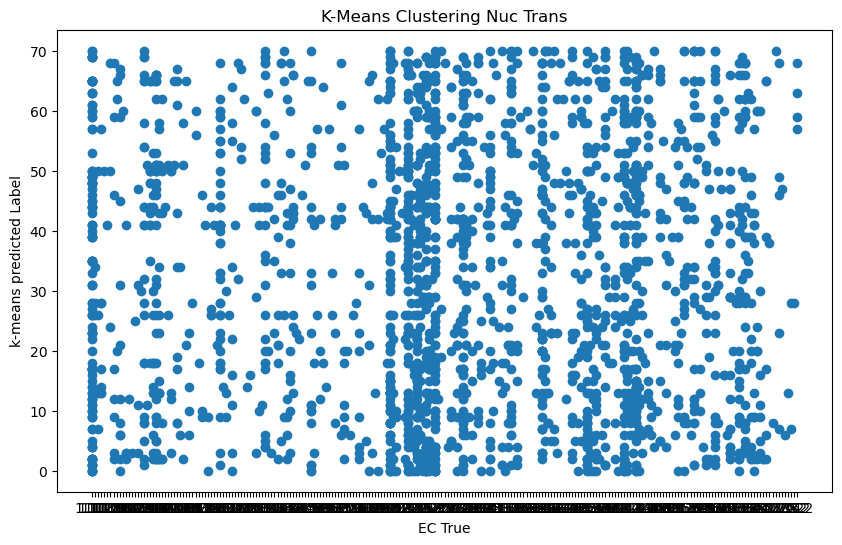

In [134]:
#dna
plt.figure(figsize=(10, 6))
# plt.scatter(ec_label_lst, cluster_labels, c=cluster_labels)
plt.scatter(ec_level_2, pred_km_lab)
plt.xlabel("EC True")
plt.ylabel("k-means predicted Label")
# cmap = plt.cm.viridis
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(min(pred_km_lab), max(pred_km_lab)))
# sm.set_array([])  # Set an empty array to avoid data association with colorbar
# plt.colorbar(sm, label='Cluster')
plt.title("K-Means Clustering Nuc Trans")
plt.show()

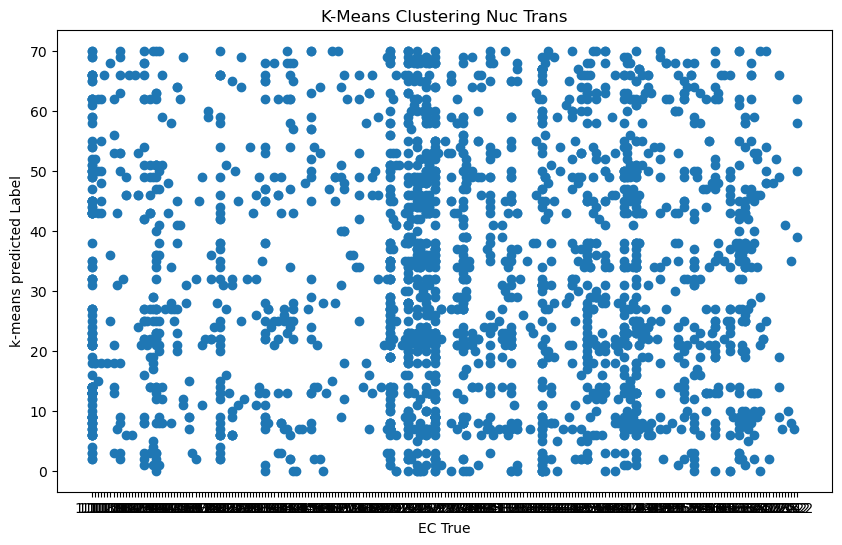

In [122]:
#nuc
plt.figure(figsize=(10, 6))
# plt.scatter(ec_label_lst, cluster_labels, c=cluster_labels)
plt.scatter(ec_level_2, pred_km_lab)
plt.xlabel("EC True")
plt.ylabel("k-means predicted Label")
# cmap = plt.cm.viridis
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(min(pred_km_lab), max(pred_km_lab)))
# sm.set_array([])  # Set an empty array to avoid data association with colorbar
# plt.colorbar(sm, label='Cluster')
plt.title("K-Means Clustering Nuc Trans")
plt.show()

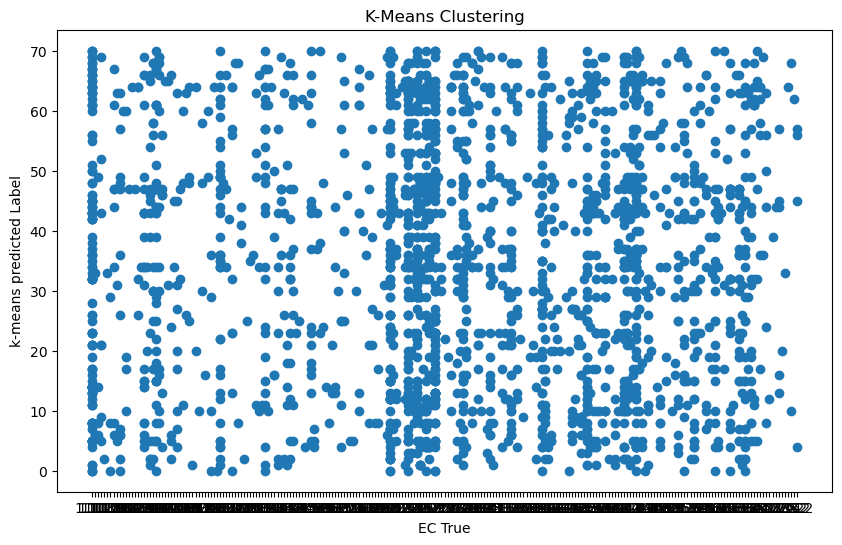

In [92]:
#lol
plt.figure(figsize=(10, 6))
# plt.scatter(ec_label_lst, cluster_labels, c=cluster_labels)
plt.scatter(ec_level_2, pred_km_lab)
plt.xlabel("EC True")
plt.ylabel("k-means predicted Label")
# cmap = plt.cm.viridis
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(min(pred_km_lab), max(pred_km_lab)))
# sm.set_array([])  # Set an empty array to avoid data association with colorbar
# plt.colorbar(sm, label='Cluster')
plt.title("K-Means Clustering")
plt.show()

In [6]:
class_embeddings, min_embeddings, max_embeddings, avg_embeddings = get_embedding_stats(embeddings)
for embeds in [class_embeddings, min_embeddings]:
    similarity_matrix = compute_cosine_similarity_in_chunks(embeds, chunk_size=1000)
    !date
    plt.figure(figsize=(6,6), dpi = 600)
    ax = plt.gca()
    ax.xaxis.set_ticks_position('top')
    # ax = sns.heatmap(similarity_matrix.numpy(), xticklabels=labels, yticklabels=labels) #, cmap=plt.cm.Blues
    plt.xticks(fontsize=1)
    plt.yticks(fontsize=1)
    print(tokenizer.name_or_path)
    sns.heatmap(similarity_matrix, annot=False, fmt=".2f", cmap=plt.cm.Blues, annot_kws={"size": 3}, xticklabels=labels, yticklabels=labels)
    !date